# Rudiments of Natural Language Processing: Transformer

This is the fourth part of the NLP workshop at the Center for Machine Learning. In this notebook we switch from the earlier introduced attention to the transformer architecture. We do the following:

*   Gather some prerequisites
*   Restore previous datapipes, vocabulary, and model
*   Switch from attention to self-attention
*   Introduce the transformer architecture
*   Introduce positional embeddings
*   Train and evaluate transformer models



## Prerequisites

Before you even start go to the menu above and make sure that your execution environment uses the GPU. Otherwise the model will train very slowly. If you change the environment later you will need to rerun the notebook from the begining. Now install the missing dependencies:

In [ ]:
!pip install portalocker

Import the necessary modules:

In [3]:
import google.colab as colab
import matplotlib.pyplot as plt
import pickle
import torch
import torchdata
import torchtext

In the first notebook we saved some data in your home directory on the google drive. To read these data mount your drive:

In [ ]:
colab.drive.mount('/content/drive')

Your home directory is now mounted as `drive/MyDrive`. Check it by listing its contents:

In [ ]:
!ls drive/MyDrive/

You should see the files `vocab.pkl`, `train_data.csv` and `valid_data.csv`. If not run the first notebook to produce them.

## Datapipes, vocabulary, and model

In the previous notebook we created datapipes that read the training and validation data. Create them again:

In [6]:
def decode(sample):
    label0, *index1 = sample
    label0 = float(label0)
    index1 = torch.tensor([int(index0) for index0 in index1])
    return label0, index1

def collate(batch):
    label1, index2 = zip(*batch)
    label1 = torch.tensor(label1)
    index2 = torch.nn.utils.rnn.pad_sequence(index2, padding_value = 0, batch_first = True)
    return label1, index2

train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)
train_pipe = train_pipe.shuffle(buffer_size = 16384)
train_pipe = train_pipe.batch(64)
train_pipe = train_pipe.collate(collate)

valid_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/valid_data.csv'])
valid_pipe = valid_pipe.parse_csv()
valid_pipe = valid_pipe.map(decode)
valid_pipe = valid_pipe.batch(64)
valid_pipe = valid_pipe.collate(collate)

We also created a vocabulary and saved it to your google drive. Load it:

In [7]:
with open('drive/MyDrive/vocab.pkl', 'rb') as stream:
    vocab = pickle.load(stream)

Read the vocabulary size and set it as the number of unique words or word indices:

In [8]:
indices = len(vocab)

Set the number of embedding features to the previous value of four:

In [9]:
features = 4

In the previous notebook we implemented the following attention module:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = self.query @ key.transpose(1, 2)       #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, 1, frames)
        feature = weight @ value                        #(samples, 1, features)
        return feature

And the following model:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):             #(samples, frames)
        feature = self.encoder(index)     #(samples, frames, features)
        feature = self.attention(feature) #(samples, 1, features)
        logit = self.classifier(feature)  #(samples, 1, 1)
        logit = logit.flatten()           #(samples)
        return logit

Instantiate it:

In [ ]:
model = Model()

Just as a reminder print the input and output shapes for a few batches:

In [ ]:
for truth_label, index in train_pipe.header(10):
    print(index.size())
    logit = model(index)
    print(logit.size())
    print()

## Self-Attention

The attention mechanism calculates scalar products of all the frames in the sample with a single query vector:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = self.query @ key.transpose(1, 2)       #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, 1, frames)
        feature = weight @ value                        #(samples, 1, features)
        return feature, weight

Let us temporarily assume that the number of frames in each sample is a priori known:

In [ ]:
frames = 256

We now introduce a different query vector for each frame by expanding the second dimension of the queries from 1 to `frames`:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, frames, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = self.query @ key.transpose(1, 2)       #(samples, frames, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, frames, frames)
        feature = weight @ value                        #(samples, frames, features)
        return feature

Consequently the second dimension of the energies also expands from 1 to `frames` which means that scalar products with all the query vectors are now calculated. The same applies to the weights. Finally the second dimension of the output features also acquires the size of `frames`. This means that a separate set of features is now produced for each query vector. Let us now temporarily assume that the number of samples in the batch is also known:

In [ ]:
samples = 64

So far the queries are equal for all samples in the batch. Let us now make them different be expanding their first dimension from 1 to `samples`. This does not change the shapes of other tensors because the first dimension of the queries was anyway broadcasted to `samples`:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(samples, frames, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = self.query @ key.transpose(1, 2)       #(samples, frames, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, frames, frames)
        feature = weight @ value                        #(samples, frames, features)
        return feature

Now the queries have the same shape as the input features which allows us to actually use these features as queries:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        query = feature                                 #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = query @ key.transpose(1, 2)            #(samples, frames, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, frames, frames)
        feature = weight @ value                        #(samples, frames, features)
        return feature, weight

The keys and values are the input features multiplied by matrices of trainable parameters. Let us introduce an analogous matrix for the queries:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.weightQ = torch.nn.Parameter(torch.empty(features, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.weightQ)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        query = feature @ self.weightQ                  #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = query @ key.transpose(1, 2)            #(samples, frames, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, frames, frames)
        feature = weight @ value                        #(samples, frames, features)
        return feature

This is the self-attention mechanism. It basically calculates scalar products of each frame with each other frame in the same sample. The resulting weights reflect how important each frame is to each other frame. The trainable matrices for queries and keys just introduce a non-orthonormal scalar product. The matrix for values makes the output features be linear combinations of the input ones. It turns out that the softmax function behaves better if the energies are normalized in the following way:

In [14]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.weightQ = torch.nn.Parameter(torch.empty(features, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.weightQ)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        query = feature @ self.weightQ                  #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = query @ key.transpose(1, 2)            #(samples, frames, frames)
        energy = energy / torch.tensor(features).sqrt() #(samples, frames, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, frames, frames)
        feature = weight @ value                        #(samples, frames, features)
        return feature

This is the final version of the self-attention module. Note that ordinary attention returns a single feature vector for each sample. Contrarywise the self-attention returns a separate feature vector for every frame in the sample. In other words the output features from self-atention have the same shape as its input features.

## Classification with Self-Attention

Recall our first model that simply averages the embedding features over frames:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):            #(samples, frames)
        feature = self.encoder(index)    #(samples, frames, features)
        feature = feature.mean(1)        #(samples, features)
        logit = self.classifier(feature) #(samples, 1)
        logit = logit.flatten()          #(samples)
        return logit

To introduce self-attention into this model we will pass the embedding features through a self-attention module and then average its output features instead of the embedding features:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):             #(samples, frames)
        feature = self.encoder(index)     #(samples, frames, features)
        feature = self.attention(feature) #(samples, frames, features)
        feature = feature.mean(1)         #(samples, features)
        logit = self.classifier(feature)  #(samples, 1)
        logit = logit.flatten()           #(samples)
        return logit

We believe that the self-attention has distilled the most useful information from the embedding features so that averaging its output features may give better results. Instantiate the model:

In [ ]:
model = Model().cuda()

Train it:

In [ ]:
history = list()
optimizer = torch.optim.Adam(model.parameters())
max_valid_accuracy = torch.tensor(0.).cuda()
for epoch in range(128):
    valid_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in valid_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    if max_valid_accuracy.lt(valid_accuracy):
        max_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'model.pt')
    train_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in train_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    history.append((epoch, train_accuracy.item(), valid_accuracy.item()))
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

    0 0.566 0.492
    1 0.766 0.668
    2 0.832 0.801
    3 0.856 0.832
    4 0.871 0.846
    5 0.882 0.857
    6 0.892 0.866
    7 0.899 0.872
    8 0.904 0.875
    9 0.910 0.877
   10 0.915 0.880
   11 0.920 0.883
   12 0.925 0.886
   13 0.931 0.886
   14 0.935 0.887
   15 0.940 0.884
   16 0.945 0.885
   17 0.949 0.886
   18 0.952 0.884
   19 0.956 0.885
   20 0.960 0.884
   21 0.963 0.884
   22 0.966 0.883
   23 0.969 0.882
   24 0.973 0.882
   25 0.975 0.881
   26 0.976 0.878
   27 0.979 0.877
   28 0.981 0.873
   29 0.983 0.874
   30 0.985 0.873
   31 0.987 0.871
   32 0.988 0.872
   33 0.990 0.870
   34 0.991 0.867
   35 0.992 0.866
   36 0.993 0.865
   37 0.994 0.864
   38 0.995 0.862
   39 0.996 0.860
   40 0.997 0.859
   41 0.997 0.858
   42 0.998 0.857
   43 0.998 0.856
   44 0.999 0.856
   45 0.999 0.853
   46 0.999 0.852
   47 0.999 0.851
   48 0.999 0.853
   49 1.000 0.850
   50 1.000 0.851
   51 1.000 0.849
   52 1.000 0.843
   53 1.000 0.851
   54 1.000 0.849
   55 1.00

Plot the accuracies:

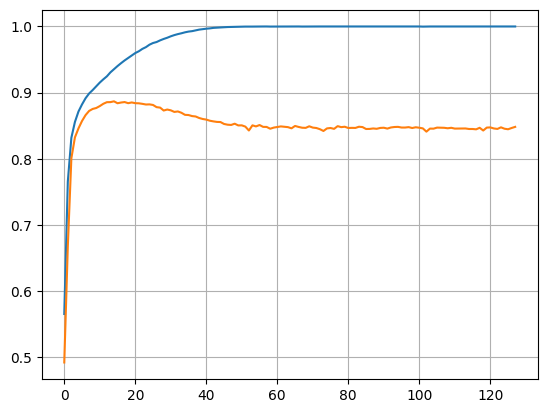

In [ ]:
epoch, train_accuracy, valid_accuracy = zip(*history)

plt.grid()
plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)

This self-attention model gives approximately the same validation accuracy as the previous models with ordinary attention. Recall that more complex models are more prone to overfitting and would thus need more training data which is unfortunately not available in the IMDB dataset.

## Transformer

Our model now uses the self-attention directly:

In [10]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):             #(samples, frames)
        feature = self.encoder(index)     #(samples, frames, features)
        feature = self.attention(feature) #(samples, frames, features)
        feature = feature.mean(1)         #(samples, features)
        logit = self.classifier(feature)  #(samples, 1)
        logit = logit.flatten()           #(samples)
        return logit

But self-attention can also make part of the so-called transformer architecture that we will now introduce. Let us start with a trivial transformer that contains only self-attention:

In [11]:
class Transformer(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.attention = Attention()
    def forward(self, feature):           #(samples, frames, features)
        feature = self.attention(feature) #(samples, frames, features)
        return feature

The model itself will now use this transformer instead of self-attention:

In [12]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.transformer = Transformer()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):               #(samples, frames)
        feature = self.encoder(index)       #(samples, frames, features)
        feature = self.transformer(feature) #(samples, frames, features)
        feature = feature.mean(1)           #(samples, features)
        logit = self.classifier(feature)    #(samples, 1)
        logit = logit.flatten()             #(samples)
        return logit

The model will not change any more and we will now work only on the transformer. Let the output features from self-attention pass through a dense network formed by two linear layers and a ReLU activation in between:

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.attention = Attention()
        self.linear1 = torch.nn.Linear(features, features * 2)
        self.linear2 = torch.nn.Linear(features * 2, features)
    def forward(self, feature):                     #(samples, frames, features)
        feature = self.attention(feature)           #(samples, frames, features)
        feature = self.linear1(feature)             #(samples, frames, features * 2)
        feature = torch.nn.functional.relu(feature) #(samples, frames, features * 2)
        feature = self.linear2(feature)             #(samples, frames, features)
        return feature

Note first that a linear layer works only on the last axis of the input tensor which is the `features` dimension in our case. So the dense network is applied separately to each frame in each sample. The dense network as a whole does not change the shape of the feature tensor but between the linear layers the number of features is increased twice. The transformer architecture also uses the so-called layer normalization after self-attention and after the dense network:

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.attention = Attention()
        self.norm1 = torch.nn.LayerNorm(features)
        self.linear1 = torch.nn.Linear(features, features * 2)
        self.linear2 = torch.nn.Linear(features * 2, features)
        self.norm2 = torch.nn.LayerNorm(features)
    def forward(self, feature):                     #(samples, frames, features)
        feature = self.attention(feature)           #(samples, frames, features)
        feature = self.norm1(feature)               #(samples, frames, features)
        feature = self.linear1(feature)             #(samples, frames, features * 2)
        feature = torch.nn.functional.relu(feature) #(samples, frames, features * 2)
        feature = self.linear2(feature)             #(samples, frames, features)
        feature = self.norm2(feature)               #(samples, frames, features)
        return feature

The transformer also employs residual connections known from the ResNet architecture. These connections are applied around the self-attention module and around the dense network:

In [15]:
class Transformer(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.attention = Attention()
        self.norm1 = torch.nn.LayerNorm(features)
        self.linear1 = torch.nn.Linear(features, features * 2)
        self.linear2 = torch.nn.Linear(features * 2, features)
        self.norm2 = torch.nn.LayerNorm(features)
    def forward(self, feature):                     #(samples, frames, features)
        residue = feature                           #(samples, frames, features)
        feature = self.attention(feature)           #(samples, frames, features)
        feature = feature + residue                 #(samples, frames, features)
        feature = self.norm1(feature)               #(samples, frames, features)
        residue = feature                           #(samples, frames, features)
        feature = self.linear1(feature)             #(samples, frames, features * 2)
        feature = torch.nn.functional.relu(feature) #(samples, frames, features)
        feature = self.linear2(feature)             #(samples, frames, features)
        feature = feature + residue                 #(samples, frames, features)
        feature = self.norm2(feature)
        return feature

This is the final version of our transformer. Create a model which uses it:

In [17]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.transformer = Transformer()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):               #(samples, frames)
        feature = self.encoder(index)       #(samples, frames, features)
        feature = self.transformer(feature) #(samples, frames, features)
        feature = feature.mean(1)           #(samples, features)
        logit = self.classifier(feature)    #(samples, 1)
        logit = logit.flatten()             #(samples)
        return logit

Instantiate the model:

In [18]:
model = Model().cuda()

Train it:

In [19]:
history = list()
optimizer = torch.optim.Adam(model.parameters())
max_valid_accuracy = torch.tensor(0.).cuda()
for epoch in range(128):
    valid_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in valid_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    if max_valid_accuracy.lt(valid_accuracy):
        max_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'model.pt')
    train_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in train_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    history.append((epoch, train_accuracy.item(), valid_accuracy.item()))
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

    0 0.545 0.489
    1 0.727 0.638
    2 0.816 0.778
    3 0.850 0.822
    4 0.870 0.839
    5 0.881 0.853
    6 0.892 0.861
    7 0.901 0.865
    8 0.908 0.870
    9 0.913 0.873
   10 0.920 0.874
   11 0.926 0.878
   12 0.930 0.880
   13 0.936 0.882
   14 0.940 0.884
   15 0.944 0.882
   16 0.948 0.881
   17 0.952 0.885
   18 0.956 0.885
   19 0.959 0.886
   20 0.962 0.884
   21 0.966 0.885
   22 0.968 0.882
   23 0.970 0.884
   24 0.973 0.883
   25 0.977 0.881
   26 0.977 0.882
   27 0.980 0.879
   28 0.982 0.877
   29 0.984 0.876
   30 0.985 0.875
   31 0.987 0.877
   32 0.988 0.874
   33 0.989 0.873
   34 0.991 0.869
   35 0.991 0.872
   36 0.992 0.868
   37 0.993 0.869
   38 0.994 0.867
   39 0.995 0.868
   40 0.993 0.863
   41 0.995 0.865
   42 0.996 0.865
   43 0.996 0.863
   44 0.996 0.862
   45 0.997 0.864
   46 0.997 0.862
   47 0.997 0.862
   48 0.998 0.860
   49 0.997 0.849
   50 0.998 0.859
   51 0.998 0.855
   52 0.998 0.859
   53 0.998 0.856
   54 0.998 0.857
   55 0.99

Plot the accuracies:

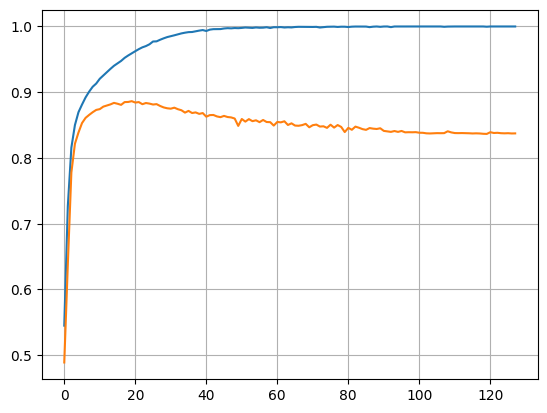

In [20]:
epoch, train_accuracy, valid_accuracy = zip(*history)

plt.grid()
plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)

In our case the complete transformer gives practically identical results as the self-attention alone. Since the transformer inputs and outputs have the same shapes it is possible to stack many transformers as ordinary layers:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.transformer1 = Transformer()
        self.transformer2 = Transformer()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):                #(samples, frames)
        feature = self.encoder(index)        #(samples, frames, features)
        feature = self.transformer1(feature) #(samples, frames, features)
        feature = self.transformer2(feature) #(samples, frames, features)
        feature = feature.mean(1)            #(samples, features)
        logit = self.classifier(feature)     #(samples, 1)
        logit = logit.flatten()              #(samples)
        return logit

We will not train this model because it would take quite some time on a free colab GPU.

## Positional embedding

So far our models completely neglected the order of words. To take it into account we will now assign embeddings not only to unique words but also to positions of words in the text. These are called positional embeddings as opposed to word embeddings used so far. Let us assume that a sample may consist of maximum 3000 frames and introduce a new embedding layer that assigns an embedding to each frame. If these positional embeddings have the same shape as the word embeddings they can be simply added to form the final embeddings which are fed to the transformer:

In [11]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.index_encoder = torch.nn.Embedding(indices, features)
        self.frame_encoder = torch.nn.Embedding(3000, features)
        self.transformer = Transformer()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):                                  #(samples, frames)
        samples, frames = index.size()
        frame = torch.arange(frames).cuda()                    #(frames)
        frame_feature = self.frame_encoder(frame)              #(frames, features)
        frame_feature = frame_feature.expand(samples, -1, -1)  #(samples, frames, features)
        index_feature = self.index_encoder(index)              #(samples, frames, features)
        feature = index_feature + frame_feature                #(samples, frames, features)
        feature = self.transformer(feature)                    #(samples, frames, features)
        feature = feature.mean(1)                              #(samples, features)
        logit = self.classifier(feature)                       #(samples, 1)
        logit = logit.flatten()                                #(samples)
        return logit

But a better way is to catenate the word and positional embeddings and then pass them through a new linear layer that will transform them to the final embeddings of appropriate shape:

In [16]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.index_encoder = torch.nn.Embedding(indices, features)
        self.frame_encoder = torch.nn.Embedding(3000, features)
        self.cat = torch.nn.Linear(features * 2, features)
        self.transformer = Transformer()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):                                  #(samples, frames)
        samples, frames = index.size()
        frame = torch.arange(frames).cuda()                    #(frames)
        frame_feature = self.frame_encoder(frame)              #(frames, features)
        frame_feature = frame_feature.expand(samples, -1, -1)  #(samples, frames, features)
        index_feature = self.index_encoder(index)              #(samples, frames, features)
        feature = torch.cat([index_feature, frame_feature], 2) #(samples, frames, features * 2)
        feature = self.cat(feature)                            #(samples, frames, features)
        feature = self.transformer(feature)                    #(samples, frames, features)
        feature = feature.mean(1)                              #(samples, features)
        logit = self.classifier(feature)                       #(samples, 1)
        logit = logit.flatten()                                #(samples)
        return logit

Now the final embeddings carry information on both the meaning and position of each word in the text. Instantiate the model:

In [17]:
model = Model().cuda()

Train it:

In [18]:
history = list()
optimizer = torch.optim.Adam(model.parameters())
max_valid_accuracy = torch.tensor(0.).cuda()
for epoch in range(128):
    valid_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in valid_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    if max_valid_accuracy.lt(valid_accuracy):
        max_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'drive/MyDrive/model.pt')
    train_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in train_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    history.append((epoch, train_accuracy.item(), valid_accuracy.item()))
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

    0 0.519 0.500
    1 0.702 0.578
    2 0.829 0.777
    3 0.862 0.824
    4 0.878 0.851
    5 0.892 0.862
    6 0.900 0.858
    7 0.909 0.874
    8 0.913 0.877
    9 0.922 0.873
   10 0.927 0.882
   11 0.931 0.885
   12 0.936 0.884
   13 0.943 0.889
   14 0.947 0.884
   15 0.952 0.890
   16 0.957 0.891
   17 0.959 0.889
   18 0.963 0.888
   19 0.967 0.887
   20 0.970 0.885
   21 0.971 0.886
   22 0.976 0.886
   23 0.979 0.883
   24 0.980 0.883
   25 0.981 0.883
   26 0.984 0.882
   27 0.985 0.878
   28 0.987 0.879
   29 0.987 0.880
   30 0.988 0.878
   31 0.990 0.880
   32 0.989 0.871
   33 0.990 0.874
   34 0.992 0.876
   35 0.992 0.878
   36 0.994 0.877
   37 0.993 0.873
   38 0.994 0.876
   39 0.994 0.876
   40 0.994 0.875
   41 0.995 0.876
   42 0.994 0.869
   43 0.996 0.869
   44 0.996 0.872
   45 0.997 0.874
   46 0.996 0.872
   47 0.996 0.870
   48 0.997 0.872
   49 0.996 0.871
   50 0.997 0.872
   51 0.997 0.872
   52 0.996 0.870
   53 0.998 0.870
   54 0.998 0.865
   55 0.99

Plot the accuracies:

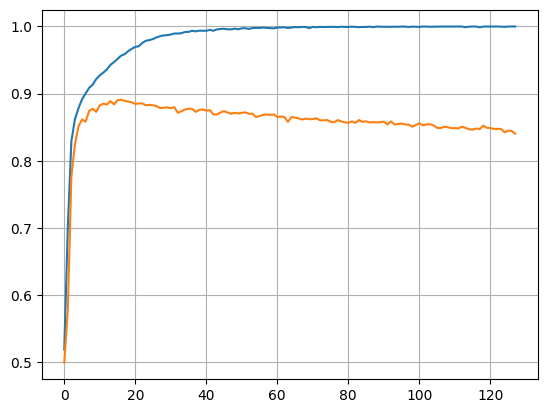

In [19]:
epoch, train_accuracy, valid_accuracy = zip(*history)

plt.grid()
plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)

It seems that the positional embeddings have slightly increased the validation accuracy. To make them work better it is necessary to conserve the division of the text into sentences.